# MRI and Alzheimers

The dataset is from [Kaggle](https://www.kaggle.com/jboysen/mri-and-alzheimers/data)  
  
This notebook is a simple exercise for different machine learning skills with MRI dataset.

## Database

1. **Cross-sectional MRI** Data in Young, Middle Aged, Nondemented and Demented Older Adults: This set consists of a cross-sectional collection of 416 subjects aged 18 to 96. For each subject, 3 or 4 individual T1-weighted MRI scans obtained in single scan sessions are included. The subjects are all right-handed and include both men and women. 100 of the included subjects over the age of 60 have been clinically diagnosed with very mild to moderate Alzheimer’s disease (AD). Additionally, a reliability data set is included containing 20 nondemented subjects imaged on a subsequent visit within 90 days of their initial session.  
  
2.  **Longitudinal MRI** Data in Nondemented and Demented Older Adults: This set consists of a longitudinal collection of 150 subjects aged 60 to 96. Each subject was scanned on two or more visits, separated by at least one year for a total of 373 imaging sessions. For each subject, 3 or 4 individual T1-weighted MRI scans obtained in single scan sessions are included. The subjects are all right-handed and include both men and women. 72 of the subjects were characterized as nondemented throughout the study. 64 of the included subjects were characterized as demented at the time of their initial visits and remained so for subsequent scans, including 51 individuals with mild to moderate Alzheimer’s disease. Another 14 subjects were characterized as nondemented at the time of their initial visit and were subsequently characterized as demented at a later visit.

## Import the packages

In [2]:
import keras
import glob
import seaborn as sns
import pandas as pd
import numpy as np
import timeit
import time
import matplotlib.pyplot as plt
import matplotlib.patches as patches

from pandas import read_csv
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier
from keras.utils import np_utils

Using TensorFlow backend.


## Load data

In [3]:
cross1=pd.read_csv('./oasis_longitudinal.csv') 
cross1 = cross1.fillna(method='ffill')
cross2=pd.read_csv('./oasis_cross-sectional.csv')
cross2 = cross2.fillna(method='ffill')
#visualize the dataset 1
cross1.head()
#visualize the dataset 2
cross2.head()
#information of dataset 1
cross1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 373 entries, 0 to 372
Data columns (total 15 columns):
Subject ID    373 non-null object
MRI ID        373 non-null object
Group         373 non-null object
Visit         373 non-null int64
MR Delay      373 non-null int64
M/F           373 non-null object
Hand          373 non-null object
Age           373 non-null int64
EDUC          373 non-null int64
SES           373 non-null float64
MMSE          373 non-null float64
CDR           373 non-null float64
eTIV          373 non-null int64
nWBV          373 non-null float64
ASF           373 non-null float64
dtypes: float64(5), int64(5), object(5)
memory usage: 43.8+ KB


 ***Graphics from the first dataset*** (oasis_longitudinal.csv)

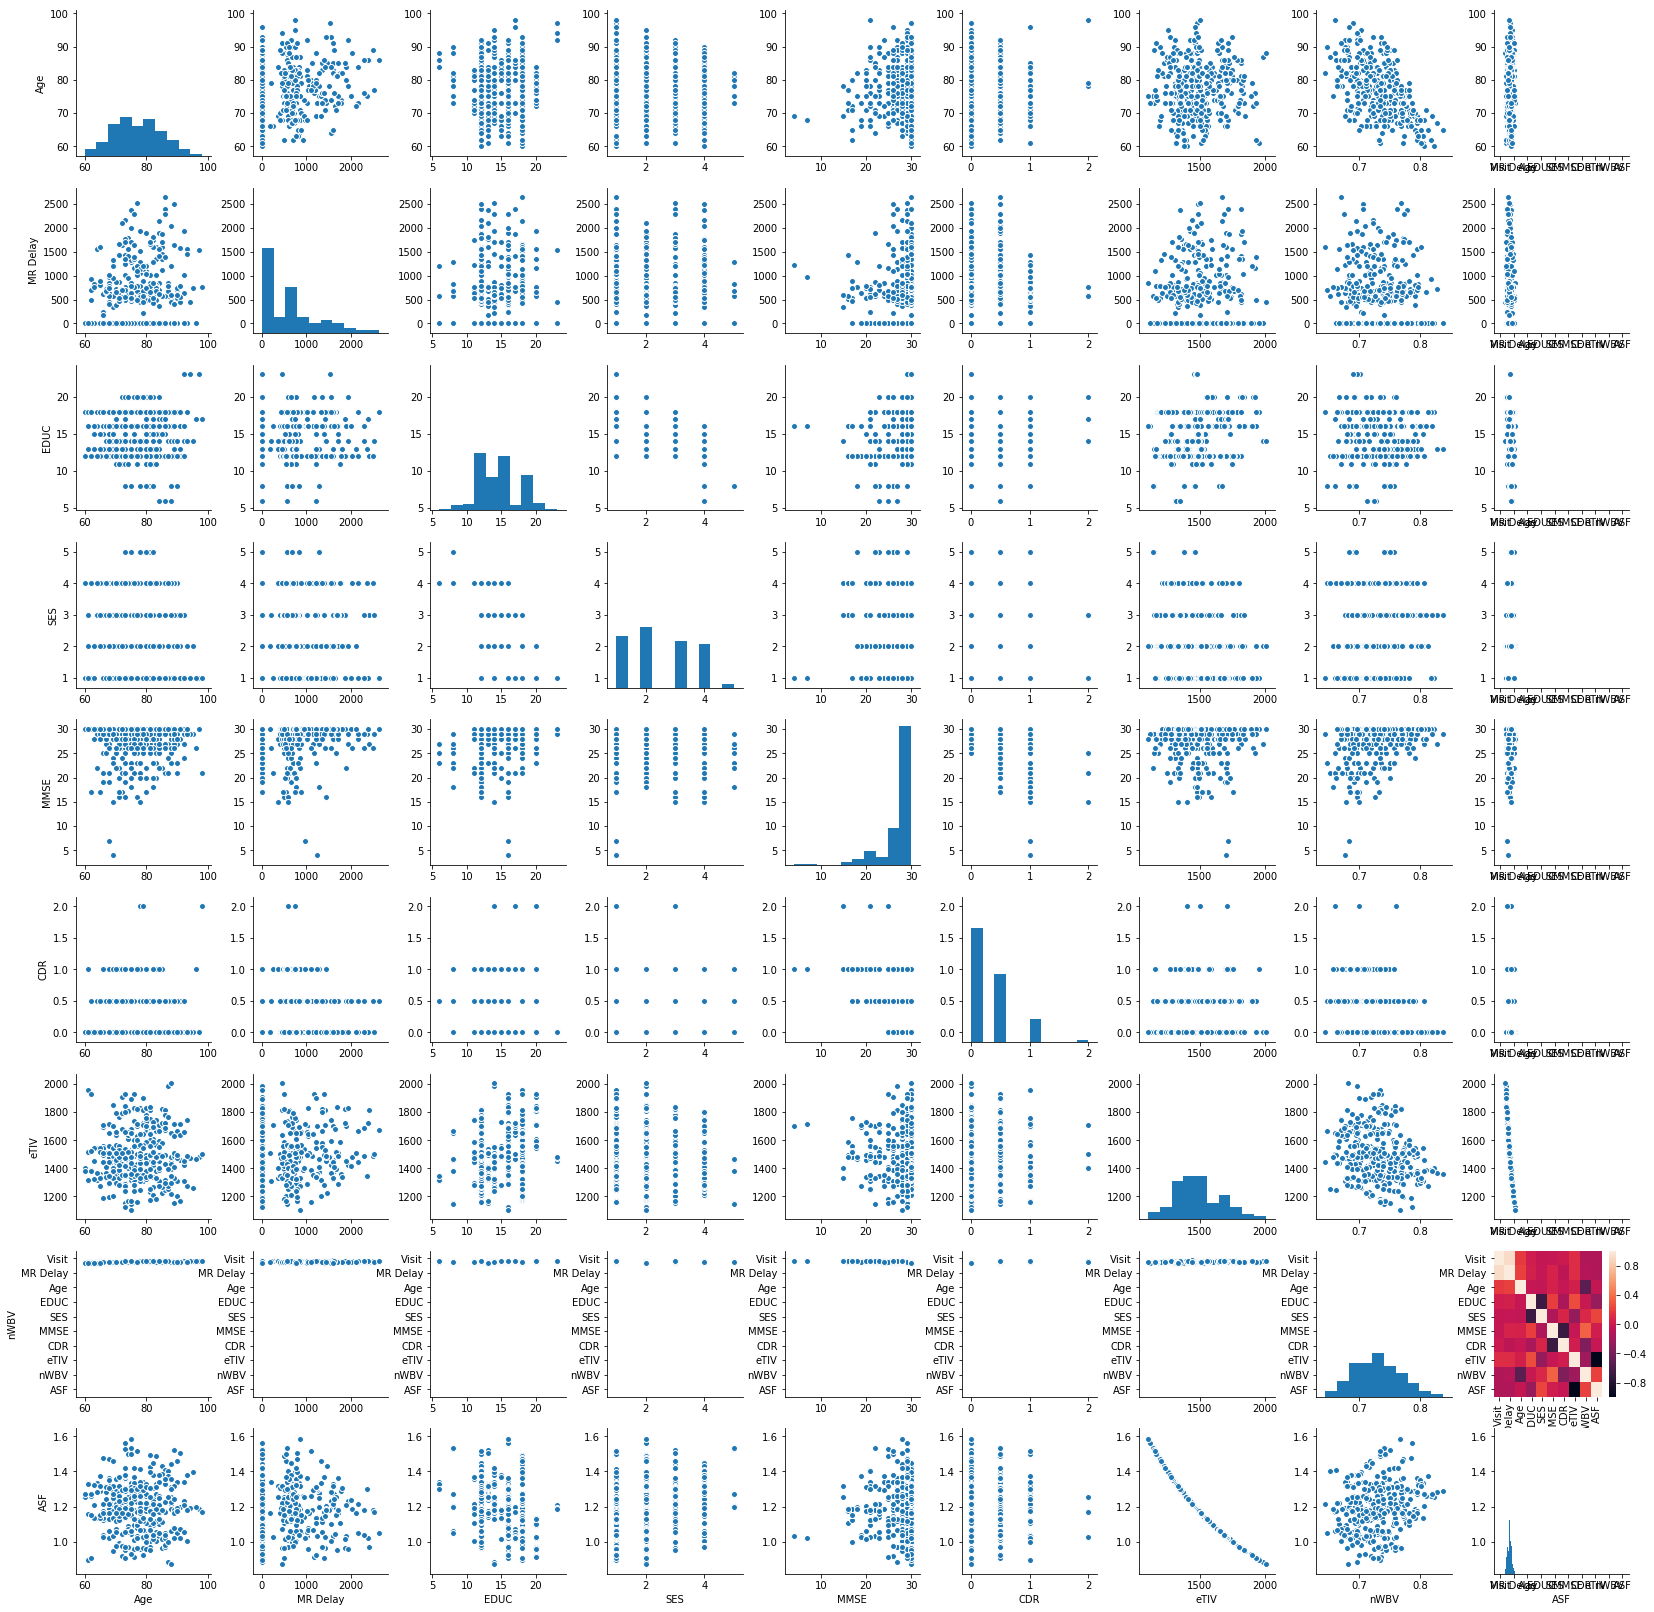

In [6]:
#Populating the interactive namespace from numpy and matplotlib
from pylab import rcParams
rcParams['figure.figsize'] = 8, 5
cols = ['Age','MR Delay', 'EDUC', 'SES', 'MMSE', 'CDR','eTIV','nWBV','ASF']
x=cross1.fillna('')
sns_plot = sns.pairplot(x[cols])

#correleation matrix
corr_matrix =cross1.corr()
rcParams['figure.figsize'] = 15, 10
sns.heatmap(corr_matrix)
plt.show()

### Prepare the data

In [7]:
cross1.drop(['MRI ID'], axis=1, inplace=True)
cross1.drop(['Visit'], axis=1, inplace=True)

#cdr=cross1["CDR"]
cross1['CDR'].replace(to_replace=0.0, value='A', inplace=True)
cross1['CDR'].replace(to_replace=0.5, value='B', inplace=True)
cross1['CDR'].replace(to_replace=1.0, value='C', inplace=True)
cross1['CDR'].replace(to_replace=2.0, value='D', inplace=True)

from sklearn.preprocessing import LabelEncoder
from sklearn.cross_validation import train_test_split
for x in cross1.columns:
    f = LabelEncoder()
    cross1[x] = f.fit_transform(cross1[x])
#visualize the transformed dataset 1
cross1.head()

C:\Users\admin\Anaconda3\envs\tensorflow-gpu\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


,Subject ID,Group,MR Delay,M/F,Hand,Age,EDUC,SES,MMSE,CDR,eTIV,nWBV,ASF
0,0,2,0,1,0,27,5,1,14,0,284,35,1
1,0,2,15,1,0,28,5,1,17,0,285,20,0
2,1,1,0,1,0,15,3,1,10,1,231,73,52
3,1,1,32,1,0,16,3,1,15,1,254,51,32
4,1,1,185,1,0,20,3,1,9,1,238,40,46


### Prepare data to train model

In [8]:
#split the dataset to training set and testing set (70% vs 30%)
train, test = train_test_split(cross1, test_size=0.3)

X_train = train[['M/F', 'Age', 'EDUC', 'SES',  'eTIV', 'ASF']]
y_train = train.CDR
X_test = test[['M/F', 'Age', 'EDUC', 'SES',  'eTIV',  'ASF']]
y_test = test.CDR

#import `StandardScaler` from `sklearn.preprocessing`
from sklearn.preprocessing import StandardScaler

#define the scaler 
scaler = StandardScaler().fit(X_train)

#scale the training set
X_train = scaler.transform(X_train)

#scale the testing set
X_test = scaler.transform(X_test)

y_train=np.ravel(y_train)
X_train=np.asarray(X_train)

y_test=np.ravel(y_test)
X_test=np.asarray(X_test)

X_train.shape
y_train.shape

(261,)

** because the separated datasets are insufficient, we need to concant the two dataset**

In [11]:
for x in cross2.columns:
    f = LabelEncoder()
    cross2[x] = f.fit_transform(cross2[x])
    
#concanting (combine) both datasets
df = pd.concat([cross1,cross2])

df = df.fillna(method='ffill')
df.head()

#split the dataset to training and testing dataset
train, test = train_test_split(cross1, test_size=0.3)
X_train1 = train[['ASF', 'Age', 'EDUC', 'Group',  'Hand', 'M/F','MMSE','MR Delay','SES','eTIV','nWBV']]
y_train1 = train.CDR
X_test1 = test[['ASF', 'Age', 'EDUC', 'Group',  'Hand', 'M/F','MMSE','MR Delay','SES','eTIV','nWBV']]
y_test1 = test.CDR

In [12]:
# Import `StandardScaler` from `sklearn.preprocessing`
from sklearn.preprocessing import StandardScaler

# Define the scaler 
scaler = StandardScaler().fit(X_train1)

# Scale the train set
X_train1 = scaler.transform(X_train1)

# Scale the test set
X_test1 = scaler.transform(X_test1)

y_train1=np.ravel(y_train1)
X_train1=np.asarray(X_train1)

y_test1=np.ravel(y_test1)
X_test1=np.asarray(X_test1)

### Linear Logistic Regression

In [13]:
from sklearn.linear_model import LogisticRegression
classifier = LogisticRegression()
classifier.fit(X_train1, y_train1)
prediction = classifier.predict(X_test1)
print('Accuracy (logistic_train): {0:f}'.format(classifier.score(X_train1, y_train1)))
print('Accuracy (logistic_test): {0:f}'.format(classifier.score(X_test1, y_test1)))

Accuracy (logistic_train): 0.789272
Accuracy (logistic_test): 0.857143


### Decision Tree Classifier

In [14]:
from sklearn.tree import DecisionTreeClassifier
classifier = DecisionTreeClassifier(max_depth=12)
classifier.fit(X_train1, y_train1)
prediction = classifier.predict(X_test1)
print('Accuracy (decision tree_train): {0:f}'.format(classifier.score(X_train1, y_train1)))
print('Accuracy (decision tree_test): {0:f}'.format(classifier.score(X_test1, y_test1)))


Accuracy (decision tree_train): 1.000000
Accuracy (decision tree_test): 0.830357


### KNN Classifier

In [15]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=2)
knn.fit(X_train1, y_train1)
print('Accuracy (knn_train): {0:f}'.format(knn.score(X_train1, y_train1)))
prediction = knn.predict(X_test1)
print('Accuracy (knn_test): {0:f}'.format(knn.score(X_test1, y_test1)))


Accuracy (knn_train): 0.908046
Accuracy (knn_test): 0.839286


### SVM Classifier

In [16]:
from sklearn.svm import SVC
#c-support SVM, we can change kernal and c
svc=SVC(kernel="linear", C=0.01)
svc.fit(X_train1, y_train1)
prediction = svc.predict(X_test1)
print('Accuracy (svm_train): {0:f}'.format(svc.score(X_train1, y_train1)))
print('Accuracy (svm_test): {0:f}'.format(svc.score(X_test1, y_test1)))

Accuracy (svm_train): 0.804598
Accuracy (svm_test): 0.830357


### deep neural network

In [17]:
import tensorflow as tf
from sklearn import metrics
X_FEATURE = 'x'  # Name of the input feature.
feature_columns = [
      tf.feature_column.numeric_column(
          X_FEATURE, shape=np.array(X_train1).shape[1:])]

classifier = tf.estimator.DNNClassifier(feature_columns=feature_columns, hidden_units=[2048,2048], n_classes=4)

train_input_fn = tf.estimator.inputs.numpy_input_fn(x={X_FEATURE: X_train1}, y=y_train1, num_epochs=100, shuffle=False)
classifier.train(input_fn=train_input_fn, steps=1000)

  # Predict.
test_input_fn = tf.estimator.inputs.numpy_input_fn(x={X_FEATURE: X_test1}, y=y_test1, num_epochs=1, shuffle=False)
predictions = classifier.predict(input_fn=test_input_fn)
y_predicted = np.array(list(p['class_ids'] for p in predictions))
y_predicted = y_predicted.reshape(np.array(y_test1).shape)

 # Score with sklearn.
score = metrics.accuracy_score(y_test1, y_predicted)
print('Accuracy (sklearn): {0:f}'.format(score))

# Score with tensorflow.
scores = classifier.evaluate(input_fn=test_input_fn)
print('Accuracy (tensorflow): {0:f}'.format(scores['accuracy']))


INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': 'C:\\Users\\admin\\AppData\\Local\\Temp\\tmp143e3yd1', '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_session_config': None, '_save_summary_steps': 100, '_tf_random_seed': 1, '_save_checkpoints_secs': 600, '_save_checkpoints_steps': None, '_log_step_count_steps': 100}
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Saving checkpoints for 1 into C:\Users\admin\AppData\Local\Temp\tmp143e3yd1\model.ckpt.
INFO:tensorflow:loss = 176.79, step = 1
INFO:tensorflow:global_step/sec: 105.954
INFO:tensorflow:loss = 4.14994, step = 101 (0.932 sec)
INFO:tensorflow:global_step/sec: 110.925
INFO:tensorflow:loss = 0.415536, step = 201 (0.902 sec)
INFO:tensorflow:Saving checkpoints for 204 into C:\Users\admin\AppData\Local\Temp\tmp143e3yd1\model.ckpt.
INFO:tensorflow:Loss for final step: 0.353242.
INFO:tensorflow:Restoring parameters from C:\Users\admin\AppData\Local\Temp\tmp143e3yd1\mod